In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Reshape,Dropout, GlobalAveragePooling2D, Input, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
tf.random.set_seed(42)

d:\testing\.testenv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
class DataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (416, 416)
        self.label_encoder = None
    
    def apply_augmentation(self, image, bbox):
        #return image, bbox

        bbox = tf.cast(bbox, tf.float32)
        
        h, w = float(self.image_size[0]), float(self.image_size[1])
        bbox_pixel = bbox * tf.constant([w, h, w, h], dtype=tf.float32)
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.flip_left_right(image)
            bbox_pixel = tf.stack([
                w - bbox_pixel[2],
                bbox_pixel[1],    
                w - bbox_pixel[0], 
                bbox_pixel[3]      
            ])
        
        if tf.random.uniform([]) > 0.5:
            angle = tf.random.uniform([], minval=-15, maxval=15) * math.pi / 180
            image = tfa.image.rotate(image, angle, fill_mode='constant', fill_value=1.0)

            
            center_x = (bbox_pixel[0] + bbox_pixel[2]) / 2
            center_y = (bbox_pixel[1] + bbox_pixel[3]) / 2
            width = bbox_pixel[2] - bbox_pixel[0]
            height = bbox_pixel[3] - bbox_pixel[1]
            
            cos_theta = tf.cos(angle)
            sin_theta = tf.sin(angle)
            new_center_x = (center_x - w/2) * cos_theta - (center_y - h/2) * sin_theta + w/2
            new_center_y = (center_x - w/2) * sin_theta + (center_y - h/2) * cos_theta + h/2
            
            expansion_factor = 1.2
            new_width = width * expansion_factor
            new_height = height * expansion_factor
            
            bbox_pixel = tf.stack([
                tf.clip_by_value(new_center_x - new_width/2, 0, w),
                tf.clip_by_value(new_center_y - new_height/2, 0, h),
                tf.clip_by_value(new_center_x + new_width/2, 0, w),
                tf.clip_by_value(new_center_y + new_height/2, 0, h)
            ])
        
        if tf.random.uniform([]) > 0.5:
            image = tf.image.random_brightness(image, 0.2)
            image = tf.image.random_contrast(image, 0.8, 1.2)
            image = tf.image.random_saturation(image, 0.8, 1.2)
            image = tf.image.random_hue(image, 0.1)
        
        if tf.random.uniform([]) > 0.5:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        
        bbox = bbox_pixel / tf.constant([w, h, w, h], dtype=tf.float32)
        return image, bbox

    def load_and_preprocess_image(self, filename, label, bbox):
        try:
            img = tf.io.read_file(filename)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.image_size)
            img = tf.cast(img, tf.float32) / 255.0

            bbox = tf.cast(bbox, tf.float32)

            img, bbox = self.apply_augmentation(img, bbox)
            return img, label, bbox
        except tf.errors.NotFoundError:
            tf.print(f"File not found: {filename}")
            img = tf.zeros(self.image_size + (3,), dtype=tf.float32)  # Return a zero-image tensor
            bbox = tf.zeros((4,), dtype=tf.float32)  # Default zero bounding box
            return img, label, bbox
        
#************************************batch size****************************************************

    def create_dataset(self, csv_file, base_dir, is_training=True, batch_size=16):
        df = pd.read_csv(csv_file)
        
        if self.label_encoder is None:
            self.label_encoder = LabelEncoder()
            df['class'] = self.label_encoder.fit_transform(df['class'])
        else:
            df['class'] = self.label_encoder.transform(df['class'])
            
        filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
        labels = df['class'].values
        labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=3)
        
        bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float32)
        
        bboxes = bboxes / np.array([self.image_size[1] - 1, self.image_size[0] - 1,
                                    self.image_size[1] - 1, self.image_size[0] - 1], dtype=np.float32)
        
        
        dataset = tf.data.Dataset.from_tensor_slices((filenames, labels_one_hot, bboxes))
  
        
        dataset = dataset.map(
            lambda f, l, b: (self.load_and_preprocess_image(f, l, b)),
            num_parallel_calls=tf.data.AUTOTUNE
        )


        dataset = dataset.filter(lambda x, y, z: x is not None)
        
        def prepare_data(img, label, bbox):
            return img, {'class_output': label, 'bbox_output': bbox}
        
        dataset = dataset.map(prepare_data)
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
        
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        
        return dataset


In [5]:
class VisionModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(416, 416, 3))        
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(416, 416, 3))
        
        for layer in base_model.layers[:-50]:
            layer.trainable = False

        x = base_model(inputs, training=True)    
        x = GlobalAveragePooling2D()(x)
        
        
        class_output = Dense(self.num_classes, activation='sigmoid', name='class_output')(x)
        bbox_output = Dense(4, activation='linear', name='bbox_output')(x)  
        
        model = Model(inputs=inputs, outputs=[class_output, bbox_output])
        return model
        
    def compile_model(self, learning_rate=1e-5):
        optimizer = AdamW(
            learning_rate=learning_rate,
            weight_decay=0.0001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        )
        
        self.model.compile(
            optimizer=optimizer,
            loss={
                'class_output': 'binary_crossentropy',
                'bbox_output': 'huber' 
            },
            loss_weights={'class_output': 1.0, 'bbox_output': 1.0},
            metrics={
                'class_output': ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)],
                'bbox_output': ['mse',tf.keras.metrics.MeanSquaredError()]
            }
        )
    
    def get_callbacks(self, model_dir='model'):
        callbacks = [
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                os.path.join(model_dir, 'model-{epoch:02d}-{val_loss:.2f}.h5'),
                monitor='val_loss',
                save_best_only=True,
                verbose=1,
                save_weights_only=False
            )
        ]
        return callbacks


In [6]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


In [7]:
def train_model(
    base_path='dataset/',
    model_save_path='model/my_model_efficientNetB0.h5',
    num_classes=3,
    epochs=100
):
    print("Initializing data processor...")
    data_processor = DataProcessor(base_path)
    
    print("Creating training dataset...")
    train_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'train', '_annotations.csv'),
        os.path.join(base_path, 'train'),
        is_training=True
    )
    
    print("Creating validation dataset...")
    valid_dataset = data_processor.create_dataset(
        os.path.join(base_path, 'valid', '_annotations.csv'),
        os.path.join(base_path, 'valid'),
        is_training=False
    )
    
    print("Building model...")
    model = VisionModel(num_classes=num_classes)
    model.compile_model()
    
    print("Starting training...")
    history = model.model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=model.get_callbacks(),
    )
    
    print(f"Saving model to {model_save_path}...")
    model.model.save(model_save_path)
    print(f"Model training completed. Model saved to: {model_save_path}")
    plot_metrics(history)
    
    return model, history, data_processor

Initializing data processor...
Creating training dataset...
Creating validation dataset...
Building model...
Starting training...
Epoch 1/100
    479/Unknown - 1148s 2s/step - loss: 0.6470 - class_output_loss: 0.6051 - bbox_output_loss: 0.0419 - class_output_accuracy: 0.4756 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mse: 0.0840 - bbox_output_mean_squared_error: 0.0840
Epoch 1: val_loss improved from inf to 0.64122, saving model to model\model-01-0.64.h5


d:\testing\.testenv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


479/479 [==============================] - 1345s 3s/step - loss: 0.6470 - class_output_loss: 0.6051 - bbox_output_loss: 0.0419 - class_output_accuracy: 0.4756 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mse: 0.0840 - bbox_output_mean_squared_error: 0.0840 - val_loss: 0.6412 - val_class_output_loss: 0.6109 - val_bbox_output_loss: 0.0304 - val_class_output_accuracy: 0.4040 - val_class_output_top_k_categorical_accuracy: 1.0000 - val_bbox_output_mse: 0.0607 - val_bbox_output_mean_squared_error: 0.0607 - lr: 1.0000e-05
Epoch 2/100
479/479 [==============================] - ETA: 0s - loss: 0.6082 - class_output_loss: 0.5787 - bbox_output_loss: 0.0295 - class_output_accuracy: 0.5004 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mse: 0.0590 - bbox_output_mean_squared_error: 0.0590
Epoch 2: val_loss did not improve from 0.64122
479/479 [==============================] - 1328s 3s/step - loss: 0.6082 - class_output_loss: 0.5787 - bbox_output_loss: 0.0295 - cl

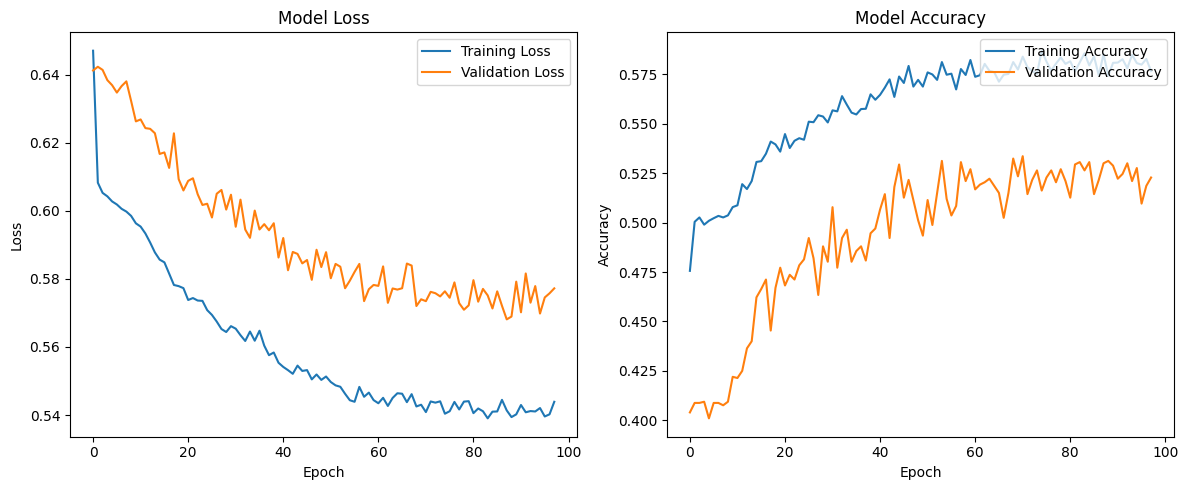

In [6]:
model, history, data_processor = train_model()

In [7]:
test_dataset = data_processor.create_dataset(
    os.path.join('dataset', 'test', '_annotations.csv'),
    os.path.join('dataset', 'test'),
    is_training=False
)

eval_results = model.model.evaluate(test_dataset, verbose=1)

total_loss, class_loss, bbox_loss, class_acc, top3_acc, bbox_mae, bbox_mse = eval_results


45/45 [==============================] - 85s 2s/step - loss: 0.5999 - class_output_loss: 0.5784 - bbox_output_loss: 0.0214 - class_output_accuracy: 0.4833 - class_output_top_k_categorical_accuracy: 1.0000 - bbox_output_mse: 0.0428 - bbox_output_mean_squared_error: 0.0428


45/45 [==============================] - 90s 2s/step
Total Loss: 0.5999
Classification Loss: 0.5784
Bounding Box Loss: 0.0214
Classification Accuracy: 0.4833
Top-3 Accuracy: 1.0000
Bounding Box MAE: 0.0428
Bounding Box MSE: 0.0428
Test Accuracy: 0.4972
F1 Score: 0.4397

Classification Report:
              precision    recall  f1-score   support

       knife       0.74      0.42      0.53       316
    long_gun       1.00      0.01      0.03       148
      pistol       0.42      0.88      0.56       254

    accuracy                           0.50       718
   macro avg       0.72      0.44      0.37       718
weighted avg       0.68      0.50      0.44       718



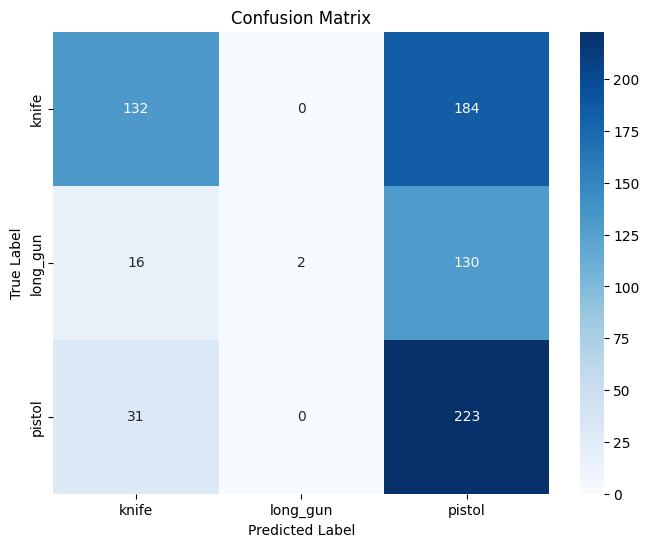

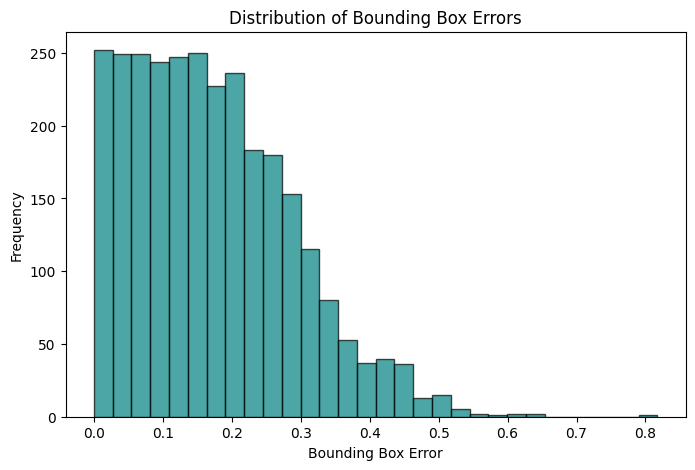

C:\Users\choud\AppData\Local\Temp\ipykernel_16468\1943964811.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loss_labels, y=loss_values, palette="magma")


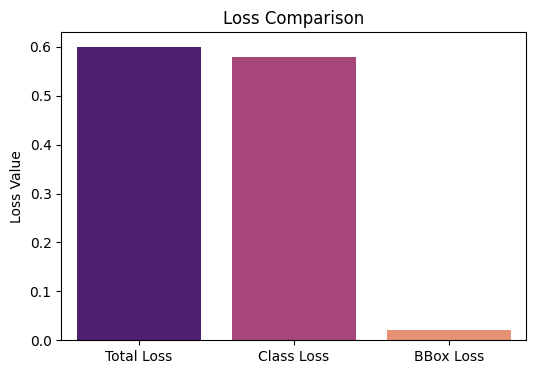

C:\Users\choud\AppData\Local\Temp\ipykernel_16468\1943964811.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette="coolwarm")


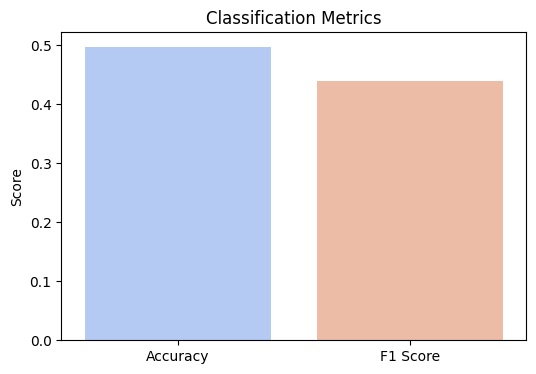

In [8]:
from sklearn.metrics import accuracy_score, f1_score

# --- 2. Make predictions ---
class_pred, bbox_pred = model.model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)  # Convert probabilities to class labels

# Extract true class labels and bounding boxes
true_class_labels = []
true_bboxes = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))
    true_bboxes.append(labels['bbox_output'])

true_class_labels = np.array(true_class_labels)
true_bboxes = np.array(true_bboxes)

# --- 3. Compute Additional Metrics ---
accuracy = accuracy_score(true_class_labels, class_pred_labels)
f1 = f1_score(true_class_labels, class_pred_labels, average='weighted')

# --- 4. Print Evaluation Results ---
print(f"Total Loss: {total_loss:.4f}")
print(f"Classification Loss: {class_loss:.4f}")
print(f"Bounding Box Loss: {bbox_loss:.4f}")
print(f"Classification Accuracy: {class_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Bounding Box MAE: {bbox_mae:.4f}")
print(f"Bounding Box MSE: {bbox_mse:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# --- 5. Classification Report ---
print("\nClassification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=data_processor.label_encoder.classes_))

# --- 6. Confusion Matrix ---
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=data_processor.label_encoder.classes_,
            yticklabels=data_processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 7. Bounding Box Error Distribution ---
bbox_errors = np.abs(true_bboxes - bbox_pred).flatten()

plt.figure(figsize=(8, 5))
plt.hist(bbox_errors, bins=30, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Bounding Box Error')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Errors')
plt.show()

# --- 8. Loss Comparison ---
loss_labels = ['Total Loss', 'Class Loss', 'BBox Loss']
loss_values = [total_loss, class_loss, bbox_loss]

plt.figure(figsize=(6, 4))
sns.barplot(x=loss_labels, y=loss_values, palette="magma")
plt.title('Loss Comparison')
plt.ylabel('Loss Value')
plt.show()

# --- 9. Classification Accuracy Bar Plot ---
metrics_labels = ['Accuracy', 'F1 Score']
metrics_values = [accuracy, f1]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics_labels, y=metrics_values, palette="coolwarm")
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.show()


In [8]:
from tensorflow.keras.models import load_model
model = load_model('model/model-88-0.57.h5')

In [9]:
base_path = 'dataset/'
data_processor = DataProcessor(base_path)
test_dataset = data_processor.create_dataset(
    os.path.join(base_path, 'test', '_annotations.csv'),
    os.path.join(base_path, 'test'),
    is_training=False
)

y_pred = model.predict(test_dataset)
print(y_pred)

45/45 [==============================] - 94s 2s/step
[array([[0.34863153, 0.16690871, 0.49464634],
       [0.49470025, 0.09049146, 0.446061  ],
       [0.35250148, 0.12714109, 0.5185111 ],
       ...,
       [0.38199815, 0.12215979, 0.5144447 ],
       [0.83152723, 0.0236262 , 0.19582377],
       [0.14644326, 0.14369905, 0.6612081 ]], dtype=float32), array([[0.26960126, 0.32228735, 0.6639386 , 0.74030477],
       [0.3217872 , 0.33288962, 0.69664866, 0.7864079 ],
       [0.2329463 , 0.25432846, 0.72281194, 0.78312224],
       ...,
       [0.2792531 , 0.35549963, 0.76071817, 0.79836565],
       [0.3658667 , 0.37269282, 0.5844853 , 0.8524019 ],
       [0.19783594, 0.19896008, 0.81110966, 0.9306742 ]], dtype=float32)]


45/45 [==============================] - 91s 2s/step
Total Loss: 0.6024
Classification Loss: 0.5809
Bounding Box Loss: 0.0215
Classification Accuracy: 0.4916
Top-3 Accuracy: 1.0000
Bounding Box MAE: 0.0430
Bounding Box MSE: 0.0430
Test Accuracy: 0.4986
F1 Score: 0.4435

Classification Report:
              precision    recall  f1-score   support

       knife       0.68      0.44      0.53       316
    long_gun       0.75      0.02      0.04       148
      pistol       0.42      0.85      0.57       254

    accuracy                           0.50       718
   macro avg       0.62      0.44      0.38       718
weighted avg       0.60      0.50      0.44       718



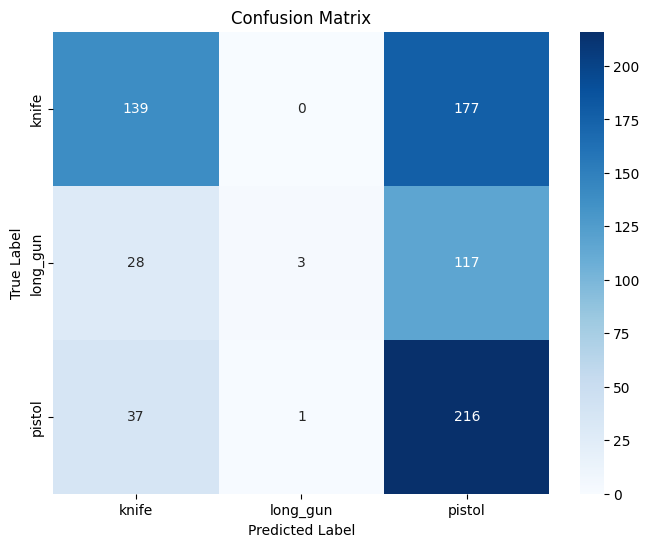

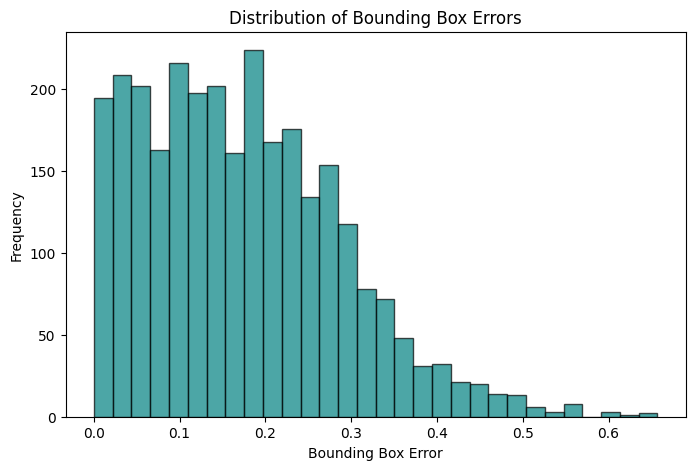

C:\Users\choud\AppData\Local\Temp\ipykernel_11272\2359142882.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loss_labels, y=loss_values, palette="magma")


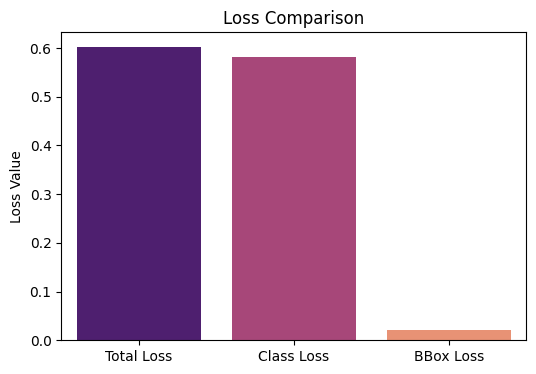

C:\Users\choud\AppData\Local\Temp\ipykernel_11272\2359142882.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_labels, y=metrics_values, palette="coolwarm")


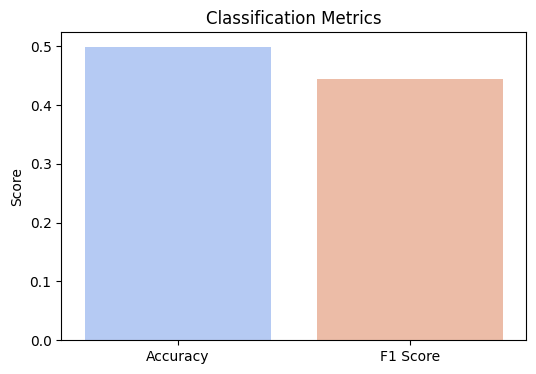

In [10]:
from sklearn.metrics import accuracy_score, f1_score

eval_results = model.evaluate(test_dataset, verbose=1)

total_loss, class_loss, bbox_loss, class_acc, top3_acc, bbox_mae, bbox_mse = eval_results


# --- 2. Make predictions ---
class_pred, bbox_pred = model.predict(test_dataset)
class_pred_labels = np.argmax(class_pred, axis=1)  # Convert probabilities to class labels

# Extract true class labels and bounding boxes
true_class_labels = []
true_bboxes = []
for images, labels in test_dataset.unbatch():
    true_class_labels.append(np.argmax(labels['class_output']))
    true_bboxes.append(labels['bbox_output'])

true_class_labels = np.array(true_class_labels)
true_bboxes = np.array(true_bboxes)

# --- 3. Compute Additional Metrics ---
accuracy = accuracy_score(true_class_labels, class_pred_labels)
f1 = f1_score(true_class_labels, class_pred_labels, average='weighted')

# --- 4. Print Evaluation Results ---
print(f"Total Loss: {total_loss:.4f}")
print(f"Classification Loss: {class_loss:.4f}")
print(f"Bounding Box Loss: {bbox_loss:.4f}")
print(f"Classification Accuracy: {class_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Bounding Box MAE: {bbox_mae:.4f}")
print(f"Bounding Box MSE: {bbox_mse:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# --- 5. Classification Report ---
print("\nClassification Report:")
print(classification_report(true_class_labels, class_pred_labels, target_names=data_processor.label_encoder.classes_))

# --- 6. Confusion Matrix ---
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(true_class_labels, class_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=data_processor.label_encoder.classes_,
            yticklabels=data_processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 7. Bounding Box Error Distribution ---
bbox_errors = np.abs(true_bboxes - bbox_pred).flatten()

plt.figure(figsize=(8, 5))
plt.hist(bbox_errors, bins=30, color='teal', alpha=0.7, edgecolor='black')
plt.xlabel('Bounding Box Error')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Errors')
plt.show()

# --- 8. Loss Comparison ---
loss_labels = ['Total Loss', 'Class Loss', 'BBox Loss']
loss_values = [total_loss, class_loss, bbox_loss]

plt.figure(figsize=(6, 4))
sns.barplot(x=loss_labels, y=loss_values, palette="magma")
plt.title('Loss Comparison')
plt.ylabel('Loss Value')
plt.show()

# --- 9. Classification Accuracy Bar Plot ---
metrics_labels = ['Accuracy', 'F1 Score']
metrics_values = [accuracy, f1]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics_labels, y=metrics_values, palette="coolwarm")
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.show()


In [ ]:
def plot_image_with_boxes(image, pred_boxes, true_boxes=None, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.imshow(image, cmap='gray')
    
    height, width = image.shape[:2]
    
    if pred_boxes is not None:
        box = pred_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='red', 
                                 linewidth=2,
                                 label='Predicted'))
    
    if true_boxes is not None:
        box = true_boxes[0]
        x = box[0] * width
        y = box[1] * height
        w = box[2] * width
        h = box[3] * height
        
        ax.add_patch(plt.Rectangle((x, y), w, h, 
                                 fill=False, 
                                 color='green', 
                                 linewidth=2,
                                 label='Ground Truth'))
    
    ax.legend()

def plot_multiple_images(test_dataset, num_images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4*rows))
    axes = axes.ravel() 
    
    for i, batch in enumerate(test_dataset.take(num_images)):
        if i >= num_images:
            break
            
        image = batch[0][0].numpy()
        true_boxes = batch[1]['bbox_output'][0].numpy()
        
        pred_boxes = model.predict(image[np.newaxis, ...])[1][0]
        
        plot_image_with_boxes(image, [pred_boxes], [true_boxes], ax=axes[i])
        axes[i].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

num_images = 24  
rows = 4      
cols = 6        

plot_multiple_images(test_dataset, num_images, rows, cols)

In [ ]:

# Function to visualize an image with bounding boxes and labels
def plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes=None, num_cols=3):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate rows needed
    
    plt.figure(figsize=(15, num_rows * 5))
    
    for i in range(num_images):
        image = images[i]
        pred_box = pred_boxes[i]
        pred_label = pred_labels[i]
        true_box = true_boxes[i] if true_boxes else None
        
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.imshow(image)
        
        # Predicted bounding box
        ax.add_patch(plt.Rectangle((pred_box[0], pred_box[1]), pred_box[2], pred_box[3],
                                   fill=False, color='red', linewidth=2, label="Predicted"))
        
        # True bounding box, if provided
        if true_box is not None:
            ax.add_patch(plt.Rectangle((true_box[0], true_box[1]), true_box[2], true_box[3],
                                       fill=False, color='green', linewidth=2, label="Ground Truth"))
        
        # Set title to display the predicted label
        label_text = "Weapon: " + pred_label if pred_label != "no weapon" else "No Weapon"
        ax.set_title(label_text, color="blue", fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Loop through the test dataset and collect images, predicted boxes, and labels
images, pred_boxes, pred_labels, true_boxes = [], [], [], []
num_images = 20  # Number of images to display

for i, batch in enumerate(test_dataset.take(num_images)):
    image = batch[0][0].numpy()
    true_box = batch[1]['bbox_output'][0].numpy()
    
    # Get predictions
    class_pred, bbox_pred = model.predict(image[np.newaxis, ...])
    pred_class = class_pred.argmax(axis=1)[0]
    pred_label = "weapon" if pred_class > 0.5 else "no weapon"
    
    # Collect for display
    images.append(image)
    pred_boxes.append(bbox_pred[0])
    pred_labels.append(pred_label)
    true_boxes.append(true_box)
    
    if i >= num_images - 1:
        break

# Plot all images in a row with labels
plot_images_with_labels(images, pred_boxes, pred_labels, true_boxes, num_cols=10)


In [ ]:
from tensorflow.keras.preprocessing import image as keras_image
def preprocess_image(img_path, model):
    img = keras_image.load_img(img_path, target_size=model.input_shape[1:3])
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array

def plot_image_with_boxes(ax, img_array, boxes, prediction_label, confidence):
    ax.imshow(img_array)
    img_height, img_width = img_array.shape[:2]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:
            xmin, xmax = xmin * img_width, xmax * img_width
            ymin, ymax = ymin * img_height, ymax * img_height
        color = 'red'  # Always red for weapons
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor=color, linewidth=2, fill=False))
        ax.text(xmin, ymin - 5, f"{prediction_label} ({confidence:.1%})",
                color=color, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    ax.axis('off')

def test_model_on_folder(folder_path, model, num_images=4, threshold=0.9):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    num_rows = (min(num_images, len(image_files)) + 1) // 2  # 2 images per row
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

    if num_rows == 1:
        axes = np.array([[axes]])  # Ensure consistent indexing for single row

    for i, img_file in enumerate(image_files[:num_images]):
        row, col = i // 2, i % 2
        img_path = os.path.join(folder_path, img_file)
        img_array = preprocess_image(img_path, model)

        # Get predictions
        class_pred, bbox_pred = model.predict(img_array, verbose=0)
        max_prob = np.max(class_pred[0])
        class_idx = np.argmax(class_pred[0])

        # Map index to class name
        class_labels = ['knife', 'gun', 'long_gun']
        prediction_label = class_labels[class_idx] if max_prob > threshold else "no weapon"

        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plot_image_with_boxes(axes[row, col], np.array(img), [bbox_pred[0]], prediction_label, max_prob)

        # Print details
        print(f"\nImage {i+1}: {img_file}")
        print(f"Prediction: {prediction_label}")
        for j, label in enumerate(class_labels):
            print(f"{label}: {class_pred[0][j]:.2%}")
        print(f"Bounding Box: {bbox_pred[0].tolist()}")
        print("-" * 50)

    # Hide empty subplot if odd number of images
    if num_images % 2 != 0:
        axes[num_rows - 1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on images in a folder
folder_path = 'try/'  # Specify the path to your folder
test_model_on_folder(folder_path, model, num_images=10, threshold=0.5)


In [ ]:
from tensorflow.keras.preprocessing import image as keras_image

def preprocess_image(img_path, model):
    img = keras_image.load_img(img_path, target_size=model.input_shape[1:3])
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def plot_image_with_boxes(ax, img_array, boxes, prediction_label):
    ax.imshow(img_array)
    img_height, img_width = img_array.shape[:2]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        if xmin < 1 and ymin < 1 and xmax < 1 and ymax < 1:
            xmin, xmax = xmin * img_width, xmax * img_width
            ymin, ymax = ymin * img_height, ymax * img_height
        color = 'red' if prediction_label in ['gun', 'knife'] else 'green'
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 edgecolor=color, linewidth=2, fill=False))
    ax.axis('off')

def test_model_on_folder(folder_path, model, num_images=4, threshold=0.4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Calculate number of rows needed (2 images per row)
    num_rows = (min(num_images, len(image_files)) + 1) // 2
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5*num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Process each image
    for i, img_file in enumerate(image_files[:num_images]):
        if i >= num_images:
            break
            
        row = i // 2
        col = i % 2
        
        img_path = os.path.join(folder_path, img_file)
        img_array = preprocess_image(img_path, model)
        
        # Get predictions
        predictions = model.predict(img_array, verbose=0)  # Reduced verbosity
        pred_classes = predictions[0][0]
        pred_boxes = predictions[1][0]
        
        # Get the class with highest probability and its value
        max_prob = max(pred_classes)
        class_idx = np.argmax(pred_classes)
        
        # Apply threshold and determine class
        if max_prob > threshold:
            prediction_label = 'gun' if class_idx == 0 else 'knife'
        else:
            prediction_label = 'no weapon'
        
        # Display image with predicted boxes
        img = keras_image.load_img(img_path)
        plot_image_with_boxes(axes[row, col], np.array(img), [pred_boxes], prediction_label)
        
        # Create detailed prediction string
        prediction_str = (f"Prediction: {prediction_label}\n"
                         f"Gun: {pred_classes[0]:.2%}\n"
                         f"Knife: {pred_classes[1]:.2%}")
        
        axes[row, col].set_title(prediction_str, fontsize=10, pad=10)
        
        # Print detailed results
        print(f"\nImage {i+1}: {img_file}")
        print(f"Prediction: {prediction_label}")
        print(f"Gun probability: {pred_classes[0]:.2%}")
        print(f"Knife probability: {pred_classes[1]:.2%}")
        print(f"Bounding Box: {pred_boxes.tolist()}")
        print("-" * 50)
    
    # Hide empty subplots if odd number of images
    if num_images % 2 != 0:
        axes[num_rows-1, 1].axis('off')
        
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Test the model on images in a folder
folder_path = 'try/'  # Specify the path to your folder
test_model_on_folder(folder_path, model, num_images=10, threshold=0.5)